In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import PIL
import tensorflow as tf
import pathlib

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
print(tf.__version__)

In [4]:
#data_dir = 'I:/download/deepLearning/datasets/keelYolo/keelTwoCalssesDataset/twoClasses/'
data_dir = 'I:/download/deepLearning/datasets/keelYolo/cutOffByMaskOutputClean/'
data_dir = pathlib.Path(data_dir).with_suffix('')

image_count = len(list(data_dir.glob('*/*.jpg')))


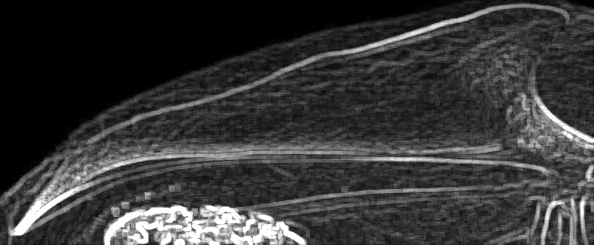

In [5]:
noFracture = list(data_dir.glob('0/*'))
PIL.Image.open(str(noFracture[0]))


In [6]:
batch_size = 4
img_height = 250
img_width = 600


In [7]:
train_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="training",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)


Found 1694 files belonging to 2 classes.
Using 1356 files for training.


In [8]:
val_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)


Found 1694 files belonging to 2 classes.
Using 338 files for validation.


In [9]:
class_names = train_ds.class_names
print(class_names)


['0', '1']


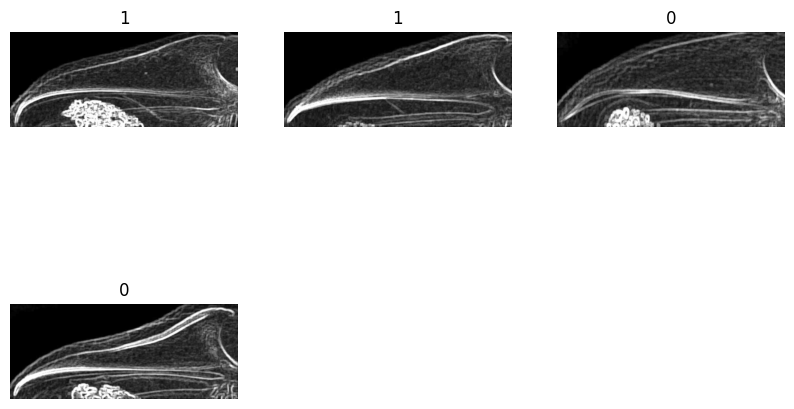

In [10]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(4):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")


In [11]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)



In [12]:
normalization_layer = layers.Rescaling(1./255)


In [13]:
normalized_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
image_batch, labels_batch = next(iter(normalized_ds))
first_image = image_batch[0]
# Notice the pixel values are now in `[0,1]`.
print(np.min(first_image), np.max(first_image))


0.0 1.0


In [14]:
num_classes = len(class_names)

model = Sequential([
  layers.Rescaling(1./255, input_shape=(img_height, img_width, 3)),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes)
])


In [15]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])


In [16]:
model.summary()


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_1 (Rescaling)     (None, 250, 600, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 250, 600, 16)      448       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 125, 300, 16)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 125, 300, 32)      4640      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 62, 150, 32)      0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 62, 150, 64)       1

In [17]:
epochs=20
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)


Epoch 1/20
339/339 [==============================] - 26s 65ms/step - loss: 0.6296 - accuracy: 0.6586 - val_loss: 0.5619 - val_accuracy: 0.6953
Epoch 2/20
339/339 [==============================] - 15s 45ms/step - loss: 0.5393 - accuracy: 0.7235 - val_loss: 0.5274 - val_accuracy: 0.7160
Epoch 3/20
339/339 [==============================] - 14s 42ms/step - loss: 0.4767 - accuracy: 0.7714 - val_loss: 0.5356 - val_accuracy: 0.7160
Epoch 4/20
339/339 [==============================] - 16s 47ms/step - loss: 0.3791 - accuracy: 0.8201 - val_loss: 0.5449 - val_accuracy: 0.7308
Epoch 5/20
339/339 [==============================] - 12s 37ms/step - loss: 0.2359 - accuracy: 0.8990 - val_loss: 0.6434 - val_accuracy: 0.7367
Epoch 6/20
339/339 [==============================] - 16s 49ms/step - loss: 0.1331 - accuracy: 0.9499 - val_loss: 1.1979 - val_accuracy: 0.7396
Epoch 7/20
339/339 [==============================] - 22s 65ms/step - loss: 0.0450 - accuracy: 0.9823 - val_loss: 1.6755 - val_accuracy:

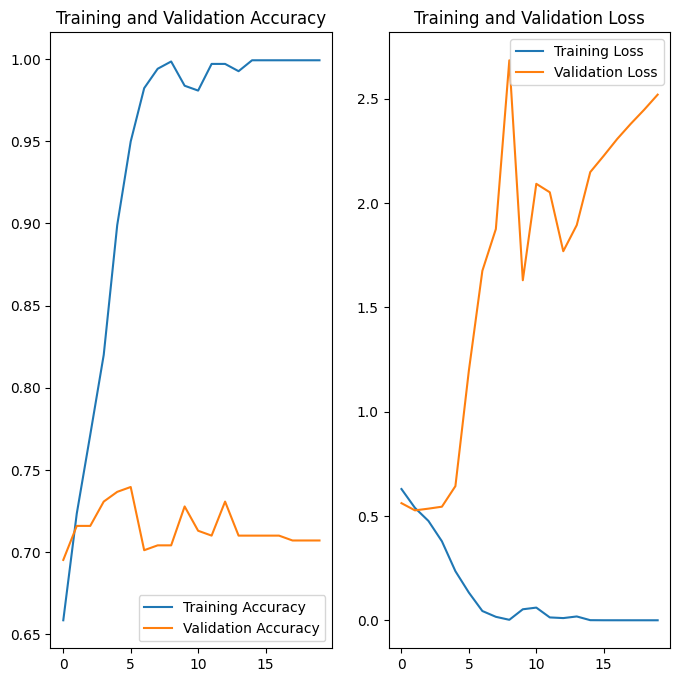

In [18]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()


In [ ]:
data_augmentation = keras.Sequential(
  [
    layers.RandomFlip("horizontal",
                      input_shape=(img_height,
                                  img_width,
                                  3)),
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.1),
  ]
)


In [ ]:
plt.figure(figsize=(10, 10))
for images, _ in train_ds.take(1):
  for i in range(4):
    augmented_images = data_augmentation(images)
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(augmented_images[0].numpy().astype("uint8"))
    plt.axis("off")


In [ ]:
model = Sequential([
  data_augmentation,
  layers.Rescaling(1./255),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Dropout(0.2),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes, name="outputs")
])


In [ ]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])


In [ ]:
model.summary()


In [ ]:
epochs = 15
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)


In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()


In [ ]:
sunflower_url = "https://storage.googleapis.com/download.tensorflow.org/example_images/592px-Red_sunflower.jpg"
sunflower_path = tf.keras.utils.get_file('Red_sunflower', origin=sunflower_url)

img = tf.keras.utils.load_img(
    sunflower_path, target_size=(img_height, img_width)
)
img_array = tf.keras.utils.img_to_array(img)
img_array = tf.expand_dims(img_array, 0) # Create a batch

predictions = model.predict(img_array)
score = tf.nn.softmax(predictions[0])

print(
    "This image most likely belongs to {} with a {:.2f} percent confidence."
    .format(class_names[np.argmax(score)], 100 * np.max(score))
)
